<a href="https://colab.research.google.com/github/techn-0/Digital_Imaging/blob/main/combined_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 밝기+각도 동시 증강 (Brightness + Rotation) 프로젝트
## Albumentations + OpenCV를 활용한 복합 증강

**목표**: 원본 이미지를 1000장으로 밝기와 각도 동시 증강
- 증강 방법: 밝기 조정 + 회전 변환
- 밝기 단계: 5단계 (0.6, 0.8, 1.0, 1.2, 1.4)
- 각도 단계: 200단계 (-180° ~ +180°)
- 총 조합: 5 × 200 = 1000개

**사용 라이브러리**:
- Albumentations: 고성능 이미지 증강
- OpenCV: 기본 이미지 처리 및 알고리즘 원리

## 1. 라이브러리 설치 및 임포트

In [1]:
# 필요한 라이브러리 설치
!pip install albumentations opencv-python-headless matplotlib numpy pillow

In [2]:
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from google.colab import files
from PIL import Image
import zipfile
from tqdm import tqdm

print(f"Albumentations 버전: {A.__version__}")
print(f"OpenCV 버전: {cv2.__version__}")

Albumentations 버전: 2.0.8
OpenCV 버전: 4.12.0


## 2. 디렉토리 설정 및 이미지 업로드

In [3]:
# 디렉토리 생성
os.makedirs('original_images', exist_ok=True)
os.makedirs('combined_augmented', exist_ok=True)
os.makedirs('combined_results', exist_ok=True)

print("디렉토리 생성 완료")
print("- original_images: 원본 이미지 저장")
print("- combined_augmented: 밝기+각도 증강된 이미지 저장")
print("- combined_results: 분석 결과 저장")

디렉토리 생성 완료
- original_images: 원본 이미지 저장
- combined_augmented: 밝기+각도 증강된 이미지 저장
- combined_results: 분석 결과 저장


In [4]:
# 이미지 업로드
print("원본 이미지를 업로드해주세요...")
uploaded = files.upload()

# 업로드된 파일을 original_images 폴더로 이동
for filename in uploaded.keys():
    os.rename(filename, f'original_images/{filename}')
    print(f"✓ {filename} 저장 완료")

# 원본 이미지 목록 확인
original_images = list(Path('original_images').glob('*'))
original_images = [str(img) for img in original_images if img.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']]

print(f"\n총 {len(original_images)}개의 원본 이미지가 준비되었습니다.")

원본 이미지를 업로드해주세요...


Saving 1000012951.jpg to 1000012951.jpg
Saving 1000012972.jpg to 1000012972.jpg
✓ 1000012951.jpg 저장 완료
✓ 1000012972.jpg 저장 완료

총 2개의 원본 이미지가 준비되었습니다.


## 3. 복합 증강 파라미터 설정

### 목표: 1000장 생성
- 밝기 단계: 5단계 (0.6, 0.8, 1.0, 1.2, 1.4 배율)
- 각도 단계: 200단계 (-180° ~ +180°)
- 총 조합: 5 × 200 = 1000개

In [5]:
# 복합 증강 파라미터 정의
BRIGHTNESS_LEVELS = [0.6, 0.8, 1.0, 1.2, 1.4]  # 5단계
ROTATION_ANGLES = np.linspace(-180, 180, 200)  # 200단계

TARGET_COUNT = len(BRIGHTNESS_LEVELS) * len(ROTATION_ANGLES)

print(f"밝기 조정 단계: {len(BRIGHTNESS_LEVELS)}개")
print(f"밝기 레벨: {BRIGHTNESS_LEVELS}")
print(f"\n각도 조정 단계: {len(ROTATION_ANGLES)}개")
print(f"각도 범위: {ROTATION_ANGLES[0]:.1f}도 ~ {ROTATION_ANGLES[-1]:.1f}도")
print(f"\n총 생성될 이미지: {len(BRIGHTNESS_LEVELS)} × {len(ROTATION_ANGLES)} = {TARGET_COUNT}장")

밝기 조정 단계: 5개
밝기 레벨: [0.6, 0.8, 1.0, 1.2, 1.4]

각도 조정 단계: 200개
각도 범위: -180.0도 ~ 180.0도

총 생성될 이미지: 5 × 200 = 1000장


## 4. 복합 증강 알고리즘

### 수학적 원리

밝기와 회전을 동시에 적용하는 복합 증강:

**1. 밝기 조정**
$$I_{bright}(x, y) = \alpha \times I_{in}(x, y)$$

**2. 회전 변환**
$$\begin{bmatrix} x' \\ y' \end{bmatrix} = \begin{bmatrix} \cos(\theta) & -\sin(\theta) \\ \sin(\theta) & \cos(\theta) \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix}$$

### 구현 방법
1. **Albumentations**: Compose로 여러 변환 조합
2. **OpenCV**: 순차적으로 변환 적용

In [6]:
def augment_combined_albumentations(image, brightness_factor, rotation_angle):
    """
    Albumentations를 사용한 밝기+각도 복합 증강

    Args:
        image: 입력 이미지 (numpy array, RGB)
        brightness_factor: 밝기 배율 (0.6~1.4)
        rotation_angle: 회전 각도 (-180~180)

    Returns:
        augmented_image: 증강된 이미지
    """
    # Albumentations Compose: 여러 변환을 순차적으로 적용
    transform = A.Compose([
        # 1. 밝기 조정
        A.RandomBrightnessContrast(
            brightness_limit=(brightness_factor - 1.0, brightness_factor - 1.0),
            contrast_limit=(0, 0),
            p=1.0
        ),
        # 2. 회전 변환
        A.Rotate(
            limit=(rotation_angle, rotation_angle),
            border_mode=cv2.BORDER_CONSTANT,
            value=0,
            p=1.0
        ),
    ])

    # 증강 적용
    augmented = transform(image=image)
    return augmented['image']


def augment_combined_opencv(image, brightness_factor, rotation_angle):
    """
    OpenCV를 사용한 밝기+각도 복합 증강

    Args:
        image: 입력 이미지 (numpy array, RGB)
        brightness_factor: 밝기 배율
        rotation_angle: 회전 각도

    Returns:
        augmented_image: 증강된 이미지
    """
    # 1. 밝기 조정
    brightened = cv2.convertScaleAbs(image, alpha=brightness_factor, beta=0)

    # 2. 회전 변환
    height, width = brightened.shape[:2]
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_angle, scale=1.0)
    rotated = cv2.warpAffine(
        brightened,
        rotation_matrix,
        (width, height),
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(0, 0, 0)
    )

    return rotated

print("✓ 복합 증강 함수 정의 완료")

✓ 복합 증강 함수 정의 완료


## 5. 알고리즘 비교 및 샘플 생성

/tmp/ipython-input-1634337652.py:22: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(
/tmp/ipython-input-1841434801.py:37: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1841434801.py:37: UserWarning: Glyph 54633 (\N{HANGUL SYLLABLE HAB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1841434801.py:37: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1841434801.py:37: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1841434801.py:37: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1841434801.py:37: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1841

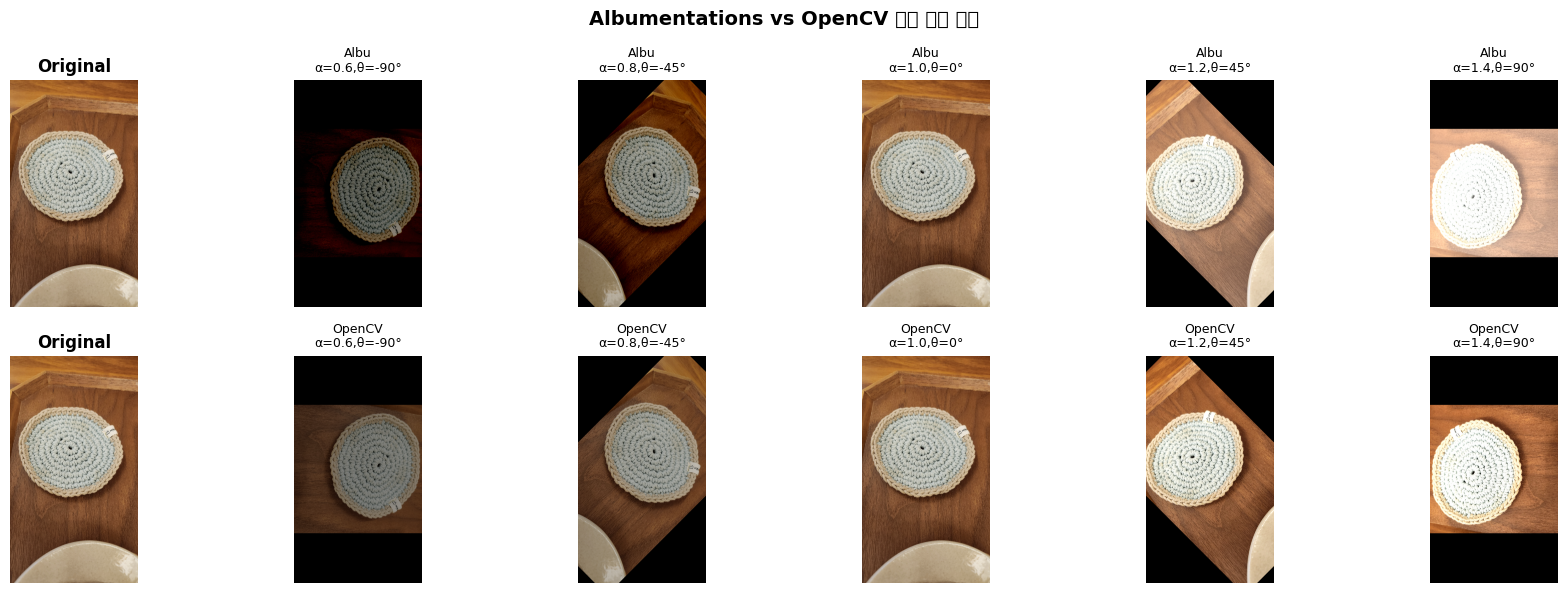

✓ 알고리즘 비교 이미지 저장: combined_results/algorithm_comparison.png


In [7]:
# 첫 번째 원본 이미지로 샘플 생성
if len(original_images) > 0:
    sample_image_path = original_images[0]
    sample_image = cv2.imread(sample_image_path)
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

    # 테스트 파라미터 (밝기 × 각도)
    test_params = [
        (0.6, -90), (0.8, -45), (1.0, 0), (1.2, 45), (1.4, 90)
    ]

    fig, axes = plt.subplots(2, 6, figsize=(18, 6))

    # 첫 번째 행: Albumentations
    axes[0, 0].imshow(sample_image)
    axes[0, 0].set_title('Original', fontweight='bold')
    axes[0, 0].axis('off')

    for idx, (brightness, angle) in enumerate(test_params, 1):
        aug_img = augment_combined_albumentations(sample_image, brightness, angle)
        axes[0, idx].imshow(aug_img)
        axes[0, idx].set_title(f'Albu\nα={brightness:.1f},θ={angle}°', fontsize=9)
        axes[0, idx].axis('off')

    # 두 번째 행: OpenCV
    axes[1, 0].imshow(sample_image)
    axes[1, 0].set_title('Original', fontweight='bold')
    axes[1, 0].axis('off')

    for idx, (brightness, angle) in enumerate(test_params, 1):
        aug_img = augment_combined_opencv(sample_image, brightness, angle)
        axes[1, idx].imshow(aug_img)
        axes[1, idx].set_title(f'OpenCV\nα={brightness:.1f},θ={angle}°', fontsize=9)
        axes[1, idx].axis('off')

    plt.suptitle('Albumentations vs OpenCV 복합 증강 비교', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('combined_results/algorithm_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ 알고리즘 비교 이미지 저장: combined_results/algorithm_comparison.png")
else:
    print("⚠ 원본 이미지를 먼저 업로드해주세요.")

## 6. 복합 증강 샘플 매트릭스

/tmp/ipython-input-1634337652.py:22: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(
/tmp/ipython-input-688780249.py:16: UserWarning: Glyph 48157 (\N{HANGUL SYLLABLE BALG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-688780249.py:16: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-688780249.py:16: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-688780249.py:16: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-688780249.py:16: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-688780249.py:16: UserWarning: Glyph 54633 (\N{HANGUL SYLLABLE HAB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-688780249.py:

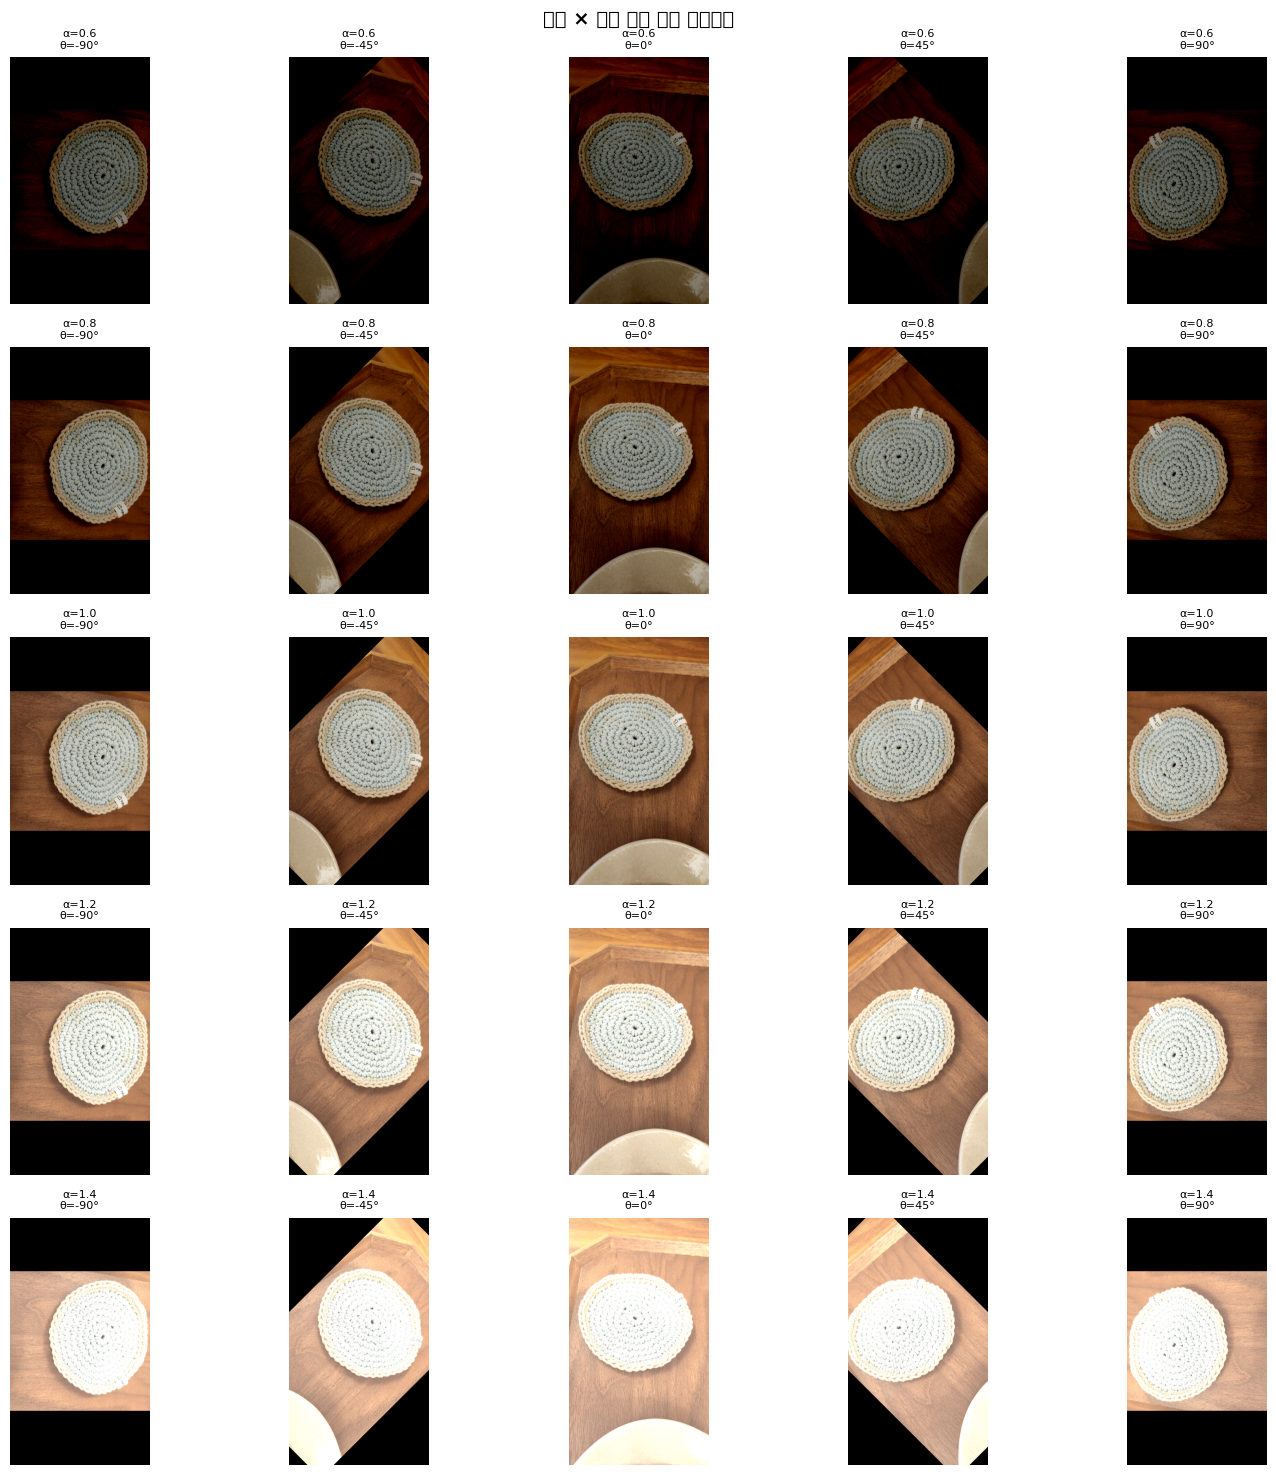

✓ 증강 매트릭스 저장: combined_results/augmentation_matrix.png


In [8]:
# 5×5 매트릭스로 다양한 조합 시각화
if len(original_images) > 0:
    test_brightnesses = [0.6, 0.8, 1.0, 1.2, 1.4]
    test_angles = [-90, -45, 0, 45, 90]

    fig, axes = plt.subplots(5, 5, figsize=(15, 15))

    for i, brightness in enumerate(test_brightnesses):
        for j, angle in enumerate(test_angles):
            aug_img = augment_combined_albumentations(sample_image, brightness, angle)
            axes[i, j].imshow(aug_img)
            axes[i, j].set_title(f'α={brightness:.1f}\nθ={angle}°', fontsize=8)
            axes[i, j].axis('off')

    plt.suptitle('밝기 × 각도 복합 증강 매트릭스', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('combined_results/augmentation_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ 증강 매트릭스 저장: combined_results/augmentation_matrix.png")

## 7. 전체 이미지 복합 증강 수행 (1000장 생성)

In [9]:
def perform_combined_augmentation(image_paths, output_dir, method='albumentations'):
    """
    전체 이미지 밝기+각도 복합 증강 수행

    Args:
        image_paths: 원본 이미지 경로 리스트
        output_dir: 출력 디렉토리
        method: 'albumentations' 또는 'opencv'
    """
    augment_func = augment_combined_albumentations if method == 'albumentations' else augment_combined_opencv

    total_augmentations = 0
    images_per_original = len(BRIGHTNESS_LEVELS) * len(ROTATION_ANGLES)

    print(f"\n{'='*70}")
    print(f"복합 증강 시작: {method.upper()} 방식")
    print(f"원본 이미지: {len(image_paths)}개")
    print(f"이미지당 생성 개수: {images_per_original}개")
    print(f"예상 총 생성 개수: {len(image_paths) * images_per_original}개")
    print(f"{'='*70}\n")

    for img_idx, img_path in enumerate(image_paths):
        # 이미지 로드
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        img_name = Path(img_path).stem

        print(f"[{img_idx+1}/{len(image_paths)}] 처리 중: {img_name}")

        # 모든 밝기와 각도의 조합에 대해 증강
        with tqdm(total=images_per_original, desc=f"  복합 증강 진행") as pbar:
            for bright_idx, brightness in enumerate(BRIGHTNESS_LEVELS):
                for angle_idx, angle in enumerate(ROTATION_ANGLES):
                    # 증강 수행
                    augmented = augment_func(image, brightness, angle)

                    # 파일명 생성
                    output_filename = f"{img_name}_b{bright_idx}_a{angle_idx:03d}.jpg"
                    output_path = os.path.join(output_dir, output_filename)

                    # 저장 (RGB -> BGR 변환)
                    cv2.imwrite(output_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))

                    total_augmentations += 1
                    pbar.update(1)

        print(f"  ✓ {img_name}: {images_per_original}개 생성 완료\n")

    print(f"\n{'='*70}")
    print(f"복합 증강 완료!")
    print(f"총 생성된 이미지: {total_augmentations}개")
    print(f"저장 위치: {output_dir}")
    print(f"{'='*70}\n")

    return total_augmentations

In [10]:
# Albumentations로 복합 증강 수행
total_count = perform_combined_augmentation(
    original_images,
    'combined_augmented',
    method='albumentations'
)


복합 증강 시작: ALBUMENTATIONS 방식
원본 이미지: 2개
이미지당 생성 개수: 1000개
예상 총 생성 개수: 2000개

[1/2] 처리 중: 1000012951


  복합 증강 진행:   0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipython-input-1634337652.py:22: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(
  복합 증강 진행: 100%|██████████| 1000/1000 [02:56<00:00,  5.67it/s]


  ✓ 1000012951: 1000개 생성 완료

[2/2] 처리 중: 1000012972


  복합 증강 진행: 100%|██████████| 1000/1000 [02:44<00:00,  6.07it/s]

  ✓ 1000012972: 1000개 생성 완료


복합 증강 완료!
총 생성된 이미지: 2000개
저장 위치: combined_augmented



## 8. 증강 결과 분석 및 통계

총 증강된 이미지 개수: 2000개
목표 달성: ✓ 성공


/tmp/ipython-input-2797180798.py:42: UserWarning: Glyph 48157 (\N{HANGUL SYLLABLE BALG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2797180798.py:42: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2797180798.py:42: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2797180798.py:42: UserWarning: Glyph 48296 (\N{HANGUL SYLLABLE BEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2797180798.py:42: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2797180798.py:42: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2797180798.py:42: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp

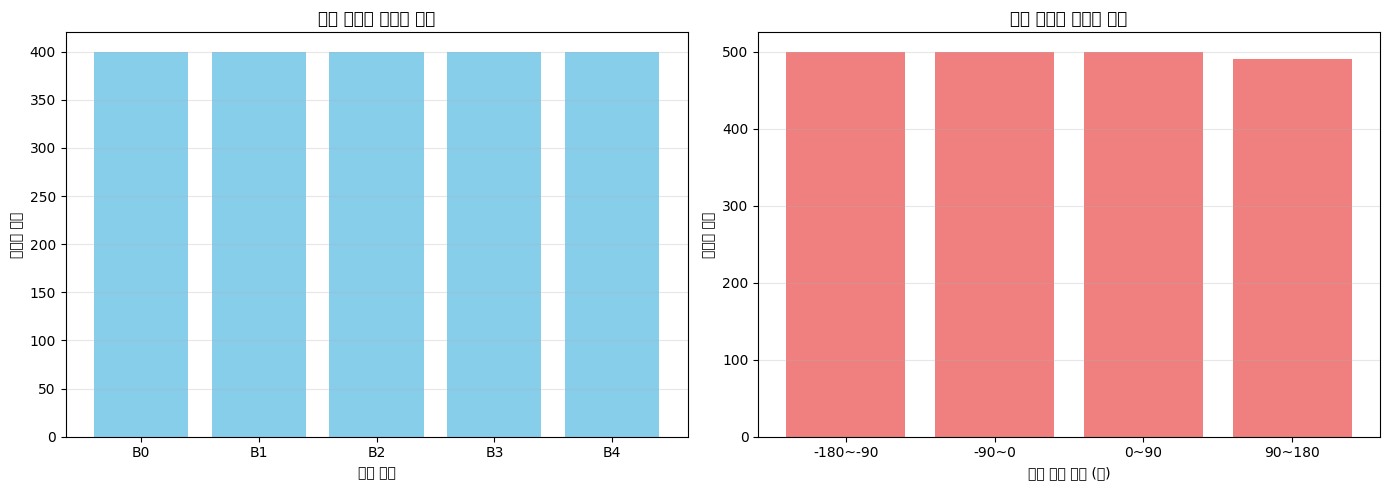

✓ 분포 분석 저장: combined_results/distribution_analysis.png


In [11]:
# 생성된 이미지 개수 확인
augmented_files = list(Path('combined_augmented').glob('*.jpg'))
print(f"총 증강된 이미지 개수: {len(augmented_files)}개")
print(f"목표 달성: {'✓ 성공' if len(augmented_files) >= 1000 else '✗ 미달성'}")

# 밝기별, 각도별 분포
brightness_counts = {f"B{i}": 0 for i in range(len(BRIGHTNESS_LEVELS))}
angle_bins = [-180, -90, 0, 90, 180]
angle_counts = {f"{angle_bins[i]}~{angle_bins[i+1]}": 0 for i in range(len(angle_bins)-1)}

for file in augmented_files:
    parts = file.stem.split('_')
    for part in parts:
        if part.startswith('b'):
            b_idx = part[1:]
            brightness_counts[f"B{b_idx}"] += 1
        if part.startswith('a'):
            a_idx = int(part[1:])
            angle = ROTATION_ANGLES[a_idx]
            for i in range(len(angle_bins)-1):
                if angle_bins[i] <= angle < angle_bins[i+1]:
                    angle_counts[f"{angle_bins[i]}~{angle_bins[i+1]}"] += 1
                    break

# 분포 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 밝기 분포
ax1.bar(brightness_counts.keys(), brightness_counts.values(), color='skyblue')
ax1.set_title('밝기 레벨별 이미지 분포', fontsize=12, fontweight='bold')
ax1.set_xlabel('밝기 레벨')
ax1.set_ylabel('이미지 개수')
ax1.grid(axis='y', alpha=0.3)

# 각도 분포
ax2.bar(angle_counts.keys(), angle_counts.values(), color='lightcoral')
ax2.set_title('회전 각도별 이미지 분포', fontsize=12, fontweight='bold')
ax2.set_xlabel('회전 각도 범위 (도)')
ax2.set_ylabel('이미지 개수')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('combined_results/distribution_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ 분포 분석 저장: combined_results/distribution_analysis.png")

## 9. 랜덤 샘플 시각화

/tmp/ipython-input-3370108040.py:17: UserWarning: Glyph 48157 (\N{HANGUL SYLLABLE BALG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3370108040.py:17: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3370108040.py:17: UserWarning: Glyph 44033 (\N{HANGUL SYLLABLE GAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3370108040.py:17: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3370108040.py:17: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3370108040.py:17: UserWarning: Glyph 54633 (\N{HANGUL SYLLABLE HAB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3370108040.py:17: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout(

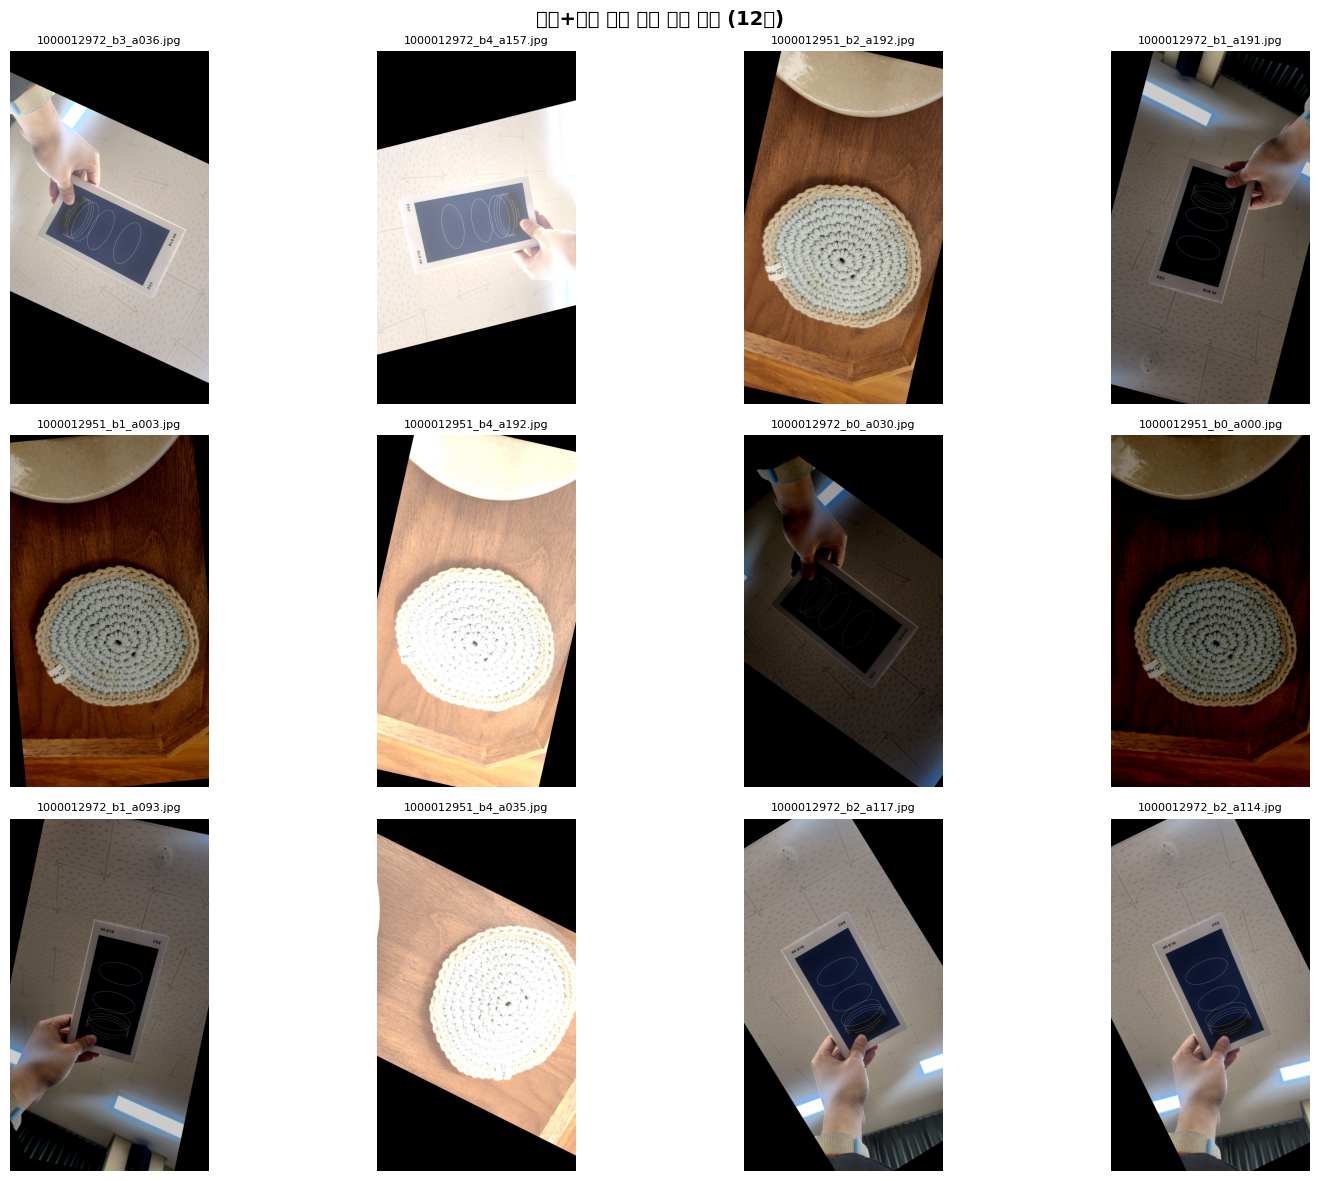

✓ 랜덤 샘플 이미지 저장: combined_results/random_samples.png


In [12]:
# 랜덤 샘플 시각화
if len(augmented_files) > 0:
    import random
    sample_files = random.sample(augmented_files, min(12, len(augmented_files)))

    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()

    for idx, img_path in enumerate(sample_files):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(img)
        axes[idx].set_title(img_path.name, fontsize=8)
        axes[idx].axis('off')

    plt.suptitle('밝기+각도 복합 증강 랜덤 샘플 (12개)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('combined_results/random_samples.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✓ 랜덤 샘플 이미지 저장: combined_results/random_samples.png")

## 10. 결과 다운로드

In [13]:
# 증강된 이미지를 ZIP 파일로 압축
zip_filename = 'combined_augmented_images.zip'

print("ZIP 파일 생성 중...")
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file in tqdm(augmented_files, desc="압축 진행"):
        zipf.write(file, file.name)

print(f"\n✓ ZIP 파일 생성 완료: {zip_filename}")
print(f"파일 크기: {os.path.getsize(zip_filename) / (1024*1024):.2f} MB")

# 다운로드
files.download(zip_filename)
print("\n다운로드가 시작되었습니다!")

ZIP 파일 생성 중...


압축 진행: 100%|██████████| 2000/2000 [02:53<00:00, 11.50it/s]


✓ ZIP 파일 생성 완료: combined_augmented_images.zip
파일 크기: 3071.11 MB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


다운로드가 시작되었습니다!
